In [3]:
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import lstsq
import numpy as np 
import h5py
import json
from scipy.io import FortranFile
import sys
import time
sys.path.append('../src/')
import trace_orbit as TORB
import orbitCoords as OC
import velocity_field as VF

In [4]:
# import a stream
GCname="AM4"
version="EDR3"
model="PII"
t,W,Xp,Yp,Zp,COM,stream=TORB.load_orbit_stream_COM(GCname,version=version,model=model)

EDR3 PII


In [5]:
A=np.ones((Xp.shape[0],6))
A[:,1],A[:,2],A[:,3] = Xp**2, Yp**2, Xp*Yp
A[:,4],A[:,5] = Xp, Yp

In [6]:
fit,resid,rnk,s=lstsq(A,Zp) 

In [7]:
N=10
xs = np.linspace(Xp.min(),Xp.max(),N)
ys = np.linspace(Yp.min(),Yp.max(),N)
X,Y=np.meshgrid(xs,ys)
Z = np.zeros(X.shape)


In [8]:
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fit[0] + fit[1]*X[r,c]**2 + fit[2]*Y[r,c]**2 + \
            fit[3]*X[r,c]*Y[r,c] + fit[4]*X[r,c] + fit[5]*Y[r,c]


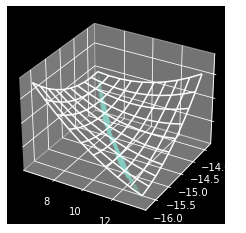

In [9]:
plt.style.use('dark_background')
fig=plt.figure()
ax = plt.subplot(111, projection='3d')
ax.plot_wireframe(X,Y,Z)#,rstride=10,cstride=10)
ax.scatter(Xp,Yp,Zp,alpha=0.1,s=1)


## Do a vector field plot of the velocity 

x' and y'

In [11]:
GCname,version,model="AM4","EDR3","PII"
dt = 0.2
ts,x,y,z,vx,vy,vz,Xp,Yp,Zp,VXp,VYp,VZp,stream,COM=VF.loadOrbitAndStream(GCname,version=version,model=model,dt=dt)

EDR3 PII


In [31]:
xcom,ycom,zcom=COM.x.value,COM.y.value,COM.z.value
tt,xprime,star_coords,indexes,velCoords,xprimeORB=VF.getOrbitalCoords(x,y,z,10*vx,10*vy,10*vz,Xp,Yp,Zp,VXp,VYp,VZp,ts,xcom,ycom,zcom)

In [32]:
cond0 = stream['energy']['Tescape'][:]>0
cond1 = xprime < 0
cond2 = xprime > 0
cond1 = np.logical_and(cond0,cond1)
cond2 = np.logical_and(cond0,cond2)    
XX,YY=xprime[cond0],star_coords[cond0,0]
my_escapetime = stream['energy']['Tescape'][cond0]
my_escapetime = 5-(my_escapetime/10) 

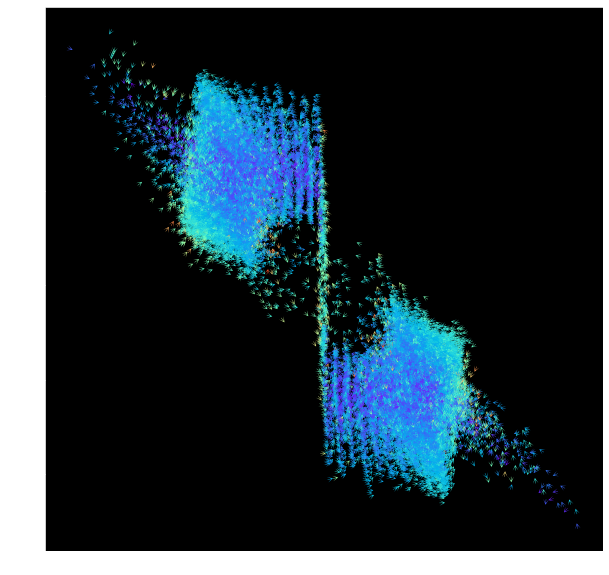

In [33]:
norm=np.sqrt(velCoords[cond0,0]**2+velCoords[cond0,1]**2)
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.quiver(xprime[cond0],star_coords[cond0,0],velCoords[cond0,0]/norm,velCoords[cond0,1]/norm,norm,**quiveropts)

In [20]:
mycolor=np.ones((XX.shape[0],4))
mycolor[:,3]=0.4

NX,NY=100,100
XXX,YYY = np.meshgrid(np.linspace(XX.min(),XX.max(),NX),np.linspace(YY.min(),YY.max(),NY))
VVXX,xedges,yedges=np.histogram2d(XX,YY,bins=[XXX[0,:],YYY[:,0]],weights=velCoords[cond0,0])
VVYY,xedges,yedges=np.histogram2d(XX,YY,bins=[XXX[0,:],YYY[:,0]],weights=velCoords[cond0,1])
TTESC,xedges,yedges=np.histogram2d(XX,YY,bins=[XXX[0,:],YYY[:,0]],weights=my_escapetime,)
counts,xedges,yedges=np.histogram2d(XX,YY,bins=[XXX[0,:],YYY[:,0]])
# print("OKOKOKOK")
VVXX/=counts
VVYY/=counts
TTESC/=counts
NORM = np.sqrt(VVXX**2 + VVYY**2)

/tmp/ipykernel_261169/1517643878.py:11: RuntimeWarning: invalid value encountered in divide
  VVXX/=counts
/tmp/ipykernel_261169/1517643878.py:12: RuntimeWarning: invalid value encountered in divide
  VVYY/=counts
/tmp/ipykernel_261169/1517643878.py:13: RuntimeWarning: invalid value encountered in divide
  TTESC/=counts


In [22]:
xcenters = [(xedges[i]+xedges[i+1])/2 for i in range(len(xedges)-1)]
ycenters = [(yedges[i]+yedges[i+1])/2 for i in range(len(yedges)-1)]
XCEN,YCEN = np.zeros(VVXX.shape),np.zeros(VVYY.shape)
for i in range(len(xcenters)-1):
    XCEN[i,:]=xcenters[i]
for i in range(len(ycenters)-1):
    YCEN[:,i]=ycenters[i]
quiveropts = dict(color=mycolor,headlength=15,headwidth=15,pivot='middle',scale=100,cmap=plt.cm.get_cmap("rainbow"))



/tmp/ipykernel_261169/1511104250.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  quiveropts = dict(color=mycolor,headlength=15,headwidth=15,pivot='middle',scale=100,cmap=plt.cm.get_cmap("rainbow"))


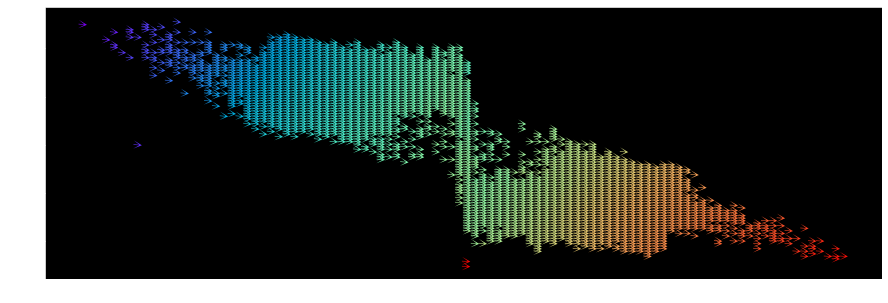

In [25]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
quiv=ax.quiver(XCEN,YCEN,VVXX/NORM,VVYY/NORM,NORM,**quiveropts)

In [13]:
indexes=np.array(indexes,dtype=int)
# star_coords[cond0].shape
WatParticle=Ws[indexes[cond0],:]
dVX=stream['galactocentric']['VX'][cond0] - WatParticle[:,3]
dVY=stream['galactocentric']['VY'][cond0] - WatParticle[:,4]
dVZ=stream['galactocentric']['VZ'][cond0] - WatParticle[:,5]

Text(0.5, 0, "x'")

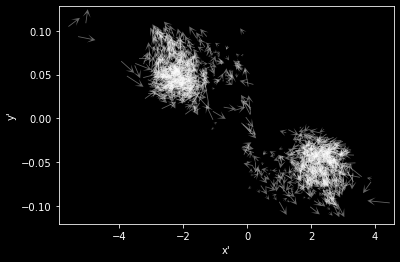

In [14]:
soa = np.array([xprime[cond0],star_coords[cond0,0],dVX,dVY])
mycolor=np.ones((dVX.shape[0],4))
mycolor[:,3]=0.4
quiveropts = dict(color=mycolor, headlength=0.1, pivot='middle', scale=.3, 
    linewidth=.05, width=.5, headwidth=.1) # common options
quiveropts = dict(color=mycolor, headlength=10,headwidth=10, pivot='middle', scale=1)
XX,YY=xprime[cond0],star_coords[cond0,0]
VXX,VYY,NN=dVX,dVY,40
plt.style.use('dark_background')

fig,ax=plt.subplots(1,1)
ax.quiver(XX[::NN],YY[::NN],VXX[::NN],VYY[::NN],**quiveropts)
ax.set_ylabel("y'")
ax.set_xlabel("x'")

#### the velocity is a bit over sampled. Standardized the velocity field on a grid|

/tmp/ipykernel_289895/358867311.py:18: RuntimeWarning: invalid value encountered in true_divide
  ax.quiver(XCEN,YCEN,VVXX/NORM,VVYY/NORM,NORM,**quiveropts)


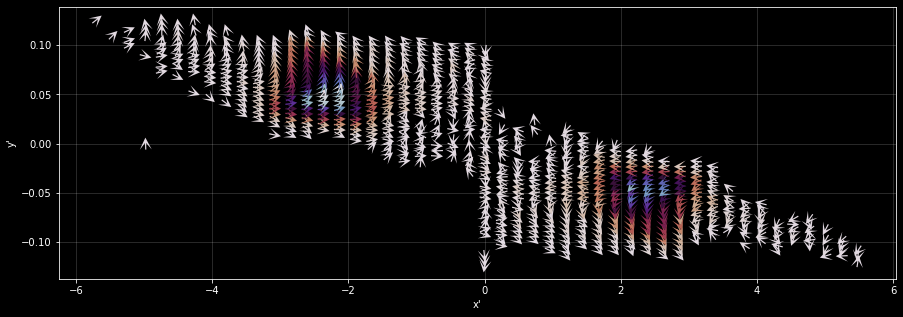

In [15]:
NX,NY=50,50
XXX,YYY = np.meshgrid(np.linspace(XX.min(),XX.max(),NX),np.linspace(YY.min(),YY.max(),NY))
VVXX,xedges,yedges=np.histogram2d(XX,YY,bins=[XXX[0,:],YYY[:,0]],weights=VXX,density=True)
VVYY,xedges,yedges=np.histogram2d(XX,YY,bins=[XXX[0,:],YYY[:,0]],weights=VYY,density=True)

NORM = np.sqrt(VVXX**2 + VVYY**2)

xcenters = [(xedges[i]+xedges[i+1])/2 for i in range(len(xedges)-1)]
ycenters = [(yedges[i]+yedges[i+1])/2 for i in range(len(yedges)-1)]
XCEN,YCEN = np.zeros(VVXX.shape),np.zeros(VVYY.shape)
for i in range(len(xcenters)-1):
    XCEN[i,:]=xcenters[i]
for i in range(len(ycenters)-1):
    YCEN[:,i]=ycenters[i]
quiveropts = dict(color=mycolor, headlength=10,headwidth=10, pivot='middle', scale=70,cmap=plt.cm.get_cmap("twilight_r"))

fig,ax=plt.subplots(1,1,figsize=(15,5))
ax.quiver(XCEN,YCEN,VVXX/NORM,VVYY/NORM,NORM,**quiveropts)
ax.set_ylabel("y'")
ax.set_xlabel("x'")
# ax.set_aspect("equal")
ax.grid("ON",alpha=0.2)

#### that's really nice

Now switch the vectors to be in the new coordinate system 

/tmp/ipykernel_289895/2214266227.py:20: RuntimeWarning: invalid value encountered in true_divide
  ax.quiver(XCEN,YCEN,VVXX/NORM,VVYY/NORM,NORM,**quiveropts)


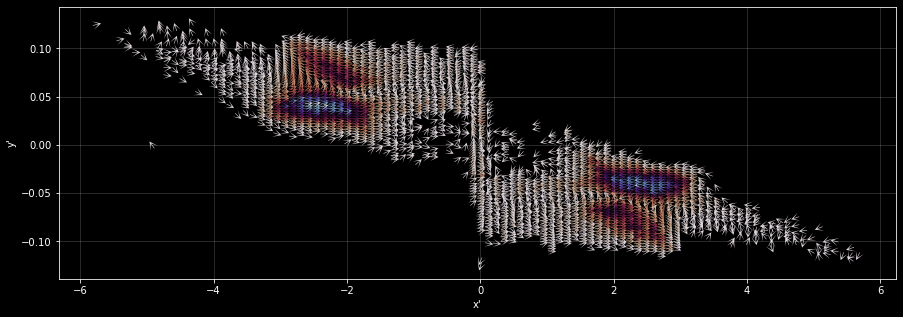

In [23]:
## how to convert properly?

NX,NY=100,100
XXX,YYY = np.meshgrid(np.linspace(XX.min(),XX.max(),NX),np.linspace(YY.min(),YY.max(),NY))
VVXX,xedges,yedges=np.histogram2d(XX,YY,bins=[XXX[0,:],YYY[:,0]],weights=velCoords[cond0,0],density=True)
VVYY,xedges,yedges=np.histogram2d(XX,YY,bins=[XXX[0,:],YYY[:,0]],weights=velCoords[cond0,1],density=True)

NORM = np.sqrt(VVXX**2 + VVYY**2)

xcenters = [(xedges[i]+xedges[i+1])/2 for i in range(len(xedges)-1)]
ycenters = [(yedges[i]+yedges[i+1])/2 for i in range(len(yedges)-1)]
XCEN,YCEN = np.zeros(VVXX.shape),np.zeros(VVYY.shape)
for i in range(len(xcenters)-1):
    XCEN[i,:]=xcenters[i]
for i in range(len(ycenters)-1):
    YCEN[:,i]=ycenters[i]
quiveropts = dict(color=mycolor, headlength=15,headwidth=15, pivot='middle', scale=100,cmap=plt.cm.get_cmap("twilight_r"))

fig,ax=plt.subplots(1,1,figsize=(15,5))
ax.quiver(XCEN,YCEN,VVXX/NORM,VVYY/NORM,NORM,**quiveropts)
ax.set_ylabel("y'")
ax.set_xlabel("x'")
# ax.set_aspect("equal")
ax.grid("ON",alpha=0.2)
fig.savefig("niceplotforherminia.png",dpi=400)

copilot suggested this for fitting the line...

$$\vec{r} = \vec{r}_0 + \vec{v}_0 t$$

where $\vec{r}$ is the position vector of the stream, $\vec{r}_0$ is the position vector of the stream at $t=0$, and $\vec{v}_0$ is the velocity vector of the stream at $t=0$. I used the `curve_fit` function from `scipy.optimize` to fit the line to the stream. The function `curve_fit` takes in a function and the data to fit to. The function I used was:
